# Best Practices - TensorFlow-Keras YOLOv4 on PASCAL VOC

## Optimizing YOLOv4 with NetsPresso Model Compressor
By following this notebook, the user can compress (x7.49 / x6.1) the YOLOv4 with performance gain (+5.01 / +5.69) by using NetsPresso Model Compressor.

 This notebook is based on the best practice video ([link](https://www.youtube.com/watch?v=MqTI212VQi0)), and it contains the following 3 parts:

  1. [Model Compression with NetsPresso Model Compressor](#compression)
  2. [Fine-Tuning the Compressed Model](#fine-tuning)
  3. [Performance Comparision](#comparision)

For more details, please visit [Docs](https://docs.netspresso.ai/docs/technology-support-1) and [Netspresso.ai](https://www.netspresso.ai/model-compressor).


<div align="center">
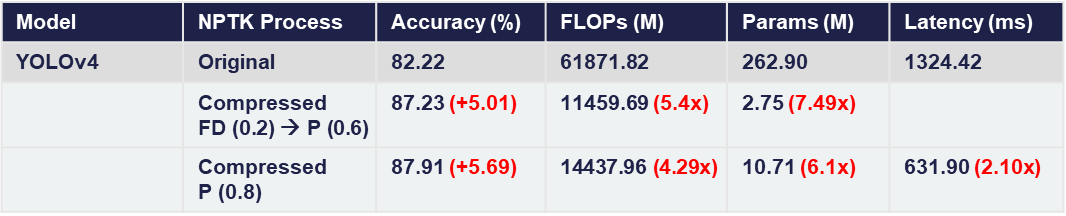
</div>
<div align='center'>
    Fig. 1 Compression result of the YOLOv4. The model's latency is measured using a Intel(R) Xeon(R) CPU (2.00GHz x86_64).
</div>



<a name="compression"></a>
# 1. Model Compression with NetsPresso Model Compressor

### Preparing the pre-trained YOLOv4 on PASCAL VOC 

Downloading the pre-trained model.
<!-- ([link](https://github.com/david8862/keras-YOLOv3-model-set)) -->

In [ ]:
! wget https://github.com/david8862/keras-YOLOv3-model-set/releases/download/v1.2.0/yolo4_efficientnet_512_voc.tar.gz
! tar -xvf yolo4_efficientnet_512_voc.tar.gz

### **YOLOv4 compression using NetsPresso Model Compressor**

<a name='compGuide'></a>

__Compression Guide__ 
1. Sign up NetsPresso Model Compressor ([link](https://compression.netspresso.ai/#/login)).
2. Upload the downloaded YOLOv4.
3. To compress the model and reproduce the best practice result, please select the following compression procedures one by one as depicted [here](#fine-tuning): 
    * For the first scompression result of Fig. 1,
        * `Tucker Decomposition` &rarr; `Recommendation(VBMF) calibration ratio: 0.2`
        * `L2 Norm Pruning` &rarr; `Recommendation(SLAMP) pruning ratio: 0.6` & `Policy: Intersection`
    * For the second compression result of Fig. 1,
        * `L2 Norm Pruning` &rarr; `Recommendation(SLAMP) pruning ratio: 0.8` & `Policy: Intersection`
        
4. Press `Compress` button, and get the compressed model. The compression result will be shown as follow.

---
* If it is hard to follow, please refer to the following user-guide video ([link](https://www.youtube.com/watch?v=MqTI212VQi0)).

<div align='center'>
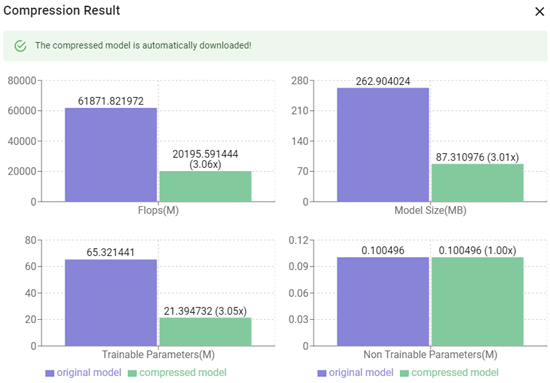
&nbsp; &nbsp; &nbsp; &nbsp;
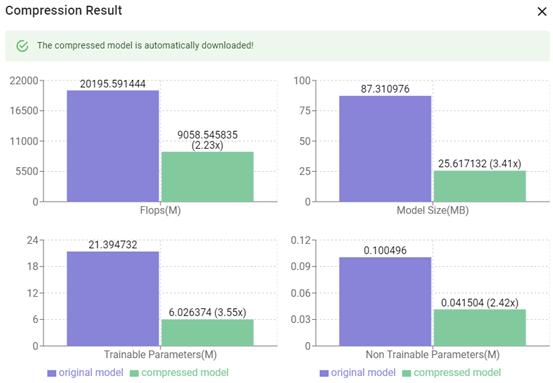
</div>
<div align='center'>
Fig 2. The results of each compression. Left: Tucker Decomposition (0.2) &rarr; L2 Norm Pruning (0.6). Right: L2 Norm Pruning (0.8).
</div>

<a name="fine-tuning"></a>
# 2. Fine-tuning the Compressed Model.
Both filter decomposition and structured pruning may induce the performance degradation, which requires additional fine-tuning process. Therefore, the fine-tuning process is necessary to compensate the performance after each compression process.
<!-- This fine-tuning process is required for each of the compression process.  -->

Here, 
* for the first compression result,
    * `Filter Decomposition` &rarr; `Fine-tuning` &rarr; `Sturctured Pruning` &rarr; `Fine-tuning`
* for the second compression result,
    * `Structured Pruning` &rarr; `Fine-tuning`

<!-- ### Cloning the YOLO repository ([link](https://github.com/david8862/keras-YOLOv3-model-set)) -->

### Setting for fine-tuning YOLOv4


Cloning the YOLOv4 code ([link](https://github.com/david8862/keras-YOLOv3-model-set))

In [ ]:
! git clone https://github.com/david8862/keras-YOLOv3-model-set.git

Please install the following packages:

In [ ]:
! apt install python3-opencv imagemagick
! pip install Cython
! pip install -r ./keras-YOLOv3-model-set/requirements.txt

! pip install keras-flops

# # Additional process for colab users
# ! pip uninstall tensorflow
# ! pip uninstall tensorflow-gpu
# ! pip install tensorflow-gpu==2.4.0
# ! pip install tensorflow-federated==0.20.0

Preparing Pascal VOC dataset

In [ ]:
! mkdir -p data/PascalVOC && \
wget -O data/PascalVOC/VOCtrainval_06-Nov-2007.tar http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar && \
wget -O data/PascalVOC/VOCtest_06-Nov-2007.tar http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar && \
wget -O data/PascalVOC/VOCtrainval_11-May-2012.tar http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar && \
wget -O data/PascalVOC/VOC2012test.tar http://pjreddie.com/media/files/VOC2012test.tar && \
pushd data/PascalVOC && \
tar xf VOCtest_06-Nov-2007.tar && \
tar xf VOCtrainval_06-Nov-2007.tar && \
tar xf VOCtrainval_11-May-2012.tar && \
popd && \
python ./keras-YOLOv3-model-set/tools/dataset_converter/voc_annotation.py --dataset_path=data/PascalVOC/VOCdevkit/ --output_path=data/PascalVOC && \
pushd data/PascalVOC && cp -rf 2007_train.txt trainval.txt && cat 2007_val.txt >> trainval.txt && cat 2012_train.txt >> trainval.txt && cat 2012_val.txt >> trainval.txt && \
cp -rf trainval.txt 2007_test.txt ./keras-YOLOv3-model-set/


### Editing files
Slight changes for fine-tuning. Reducing factor of learning rate, model loading, etc., are included in the changes.

In [ ]:
edit_list_trainpy = [
    (60,"    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, mode='min', patience=10, verbose=1, cooldown=0, min_lr=1e-10)"),
    (139,"        eval_callback = EvalCallBack(args.model_type, dataset[num_train:], anchors, class_names, args.weights_path, args.model_input_shape, args.model_pruning, log_dir, eval_epoch_interval=args.eval_epoch_interval, save_eval_checkpoint=args.save_eval_checkpoint, elim_grid_sense=args.elim_grid_sense)"),
    (160,"        strategy = tf.distribute.MirroredStrategy(devices=devices_list, cross_device_ops=tf.distribute.ReductionToOneDevice())"),
    (178,"    model.fit(data_generator(dataset[:num_train], args.batch_size, input_shape, anchors, num_classes, args.enhance_augment, rescale_interval, multi_anchor_assign=args.multi_anchor_assign),"),
    (235,"    model.fit(data_generator(dataset[:num_train], args.batch_size, input_shape, anchors, num_classes, args.enhance_augment, rescale_interval, multi_anchor_assign=args.multi_anchor_assign),")
]

edit_list_yolopy = [
    (69,"        self.yolo_model = tf.keras.models.load_model(self.model_body_path)"),
    (70,"        self.yolo_model.load_weights(self.weights_path)"),
    (340, "    parser.add_argument('--model_body_path', type=str)"),   
]

# common/callbacks.py
edit_list_callbackspy = [
    (10, 'import tensorflow as tf'),
    (49, '    def __init__(self, model_type, annotation_lines, anchors, class_names, weights_path, model_input_shape, model_pruning, log_dir, eval_epoch_interval=10, save_eval_checkpoint=False, elim_grid_sense=False):'),
    (61,"        self.eval_model = tf.keras.models.load_model(weights_path)"),
    (62,"        self.v5_decode = False")
]

# yolo3/model.py
edit_list_modelpy = [
    (9,"import tensorflow as tf"),
    (269, "    model_body = tf.keras.models.load_model(weights_path)"),
    (270, "    _, backbone_len = get_yolo3_model(model_type, num_feature_layers, num_anchors, num_classes, model_pruning=model_pruning, pruning_end_step=pruning_end_step)")
]

In [ ]:
import fileinput

def editFile(file_root, edit_list):
    with fileinput.input(files=(file_root),inplace=True) as f:
        idx = 0
        for line in f:
            if idx < len(edit_list) and f.lineno() == edit_list[idx][0]:
                print(line.replace(line,edit_list[idx][1]))
                idx+=1
            else:
              print(line,end="")

In [ ]:
editFile("./keras-YOLOv3-model-set/train.py",edit_list_trainpy)
editFile("./keras-YOLOv3-model-set/yolo.py",edit_list_yolopy)
editFile("./keras-YOLOv3-model-set/common/callbacks.py",edit_list_callbackspy)
editFile("./keras-YOLOv3-model-set/yolo3/model.py",edit_list_modelpy)

### Fine-tuning the compressed model

Determining device to use

In [ ]:
import os
import tensorflow as tf
if tf.config.experimental.list_physical_devices('GPU'):
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    print('Using GPU')
else:
    os.environ["CUDA_VISIBLE_DEVICES"] = ""
    print('Using CPU')

Fine-tuning the compressed model

In this Notebook, we fine-tune ([link](#fine-tuning)) and verify ([link](#comparision)) the model for the first compression result of Fig. 1 by default.  
`yolo4_efficientnet_512_voc_compressed_model_TD_02_L2Norm_06.h5` means the model compressed by `Tucker Decomposition (calibration ratio: 0.2)` and `L2 Norm Pruning (pruning ratio: 0.6)`.

In [ ]:
           # "yolo4_efficientnet_512_voc_compressed_model_L2Norm_08.h5"
! MODEL_PATH="yolo4_efficientnet_512_voc_compressed_model_TD_02_L2Norm_06.h5" && \ 
python ./keras-YOLOv3-model-set/train.py \
--model_type=yolo4_efficientnet \
--model_input_shape 512x512 \
--annotation_file ./data/PascalVOC/2007_train.txt \
--val_annotation_file ./data/PascalVOC/2007_test.txt \
--anchors_path ./keras-YOLOv3-model-set/configs/yolo4_anchors.txt \
--classes_path=./keras-YOLOv3-model-set/configs/voc_classes.txt \
--eval_online \
--save_eval_checkpoint \
--freeze_level 1 \
--eval_epoch_interval 100 \
--gpu_num 1 \
--optimizer 'sgd' \
--decay_type 'cosine' \
--data_shuffle \
--batch_size 32 \
--learning_rate 4e-3 \
--transfer_epoch 1 \
--total_epoch 1 \
--weights_path $MODEL_PATH

<a name="comparision"></a>
# 3. Compression Results

In this section, we visualize and verify the effectiveness of the NetsPresso Model Compressor on YOLOv4.

* [Visualizing the optimization process](#visualize)
* [Accuracy](#acc)
* [FLOPs and parameters](#flopsParams)
* [Latency](#latency)
* [Architecture of the compressed model](#layerShape)

<a name='visualize'></a>

<!-- ### Visualization of How NetsPresso Model Compressor Optimizes MobileNetV1 -->
### Visualizing the optimization process on YOLOv4

Fig.3 visualizes part of the original, decomposed and pruned YOLOv4.
Here, we applied [Tucker Decomposition](https://docs.netspresso.ai/docs/filter-decomposition-2#supported-method) and [L2 Norm Pruning](https://docs.netspresso.ai/docs/pruning#structured-pruning) to optimize the model.
<div align="center">

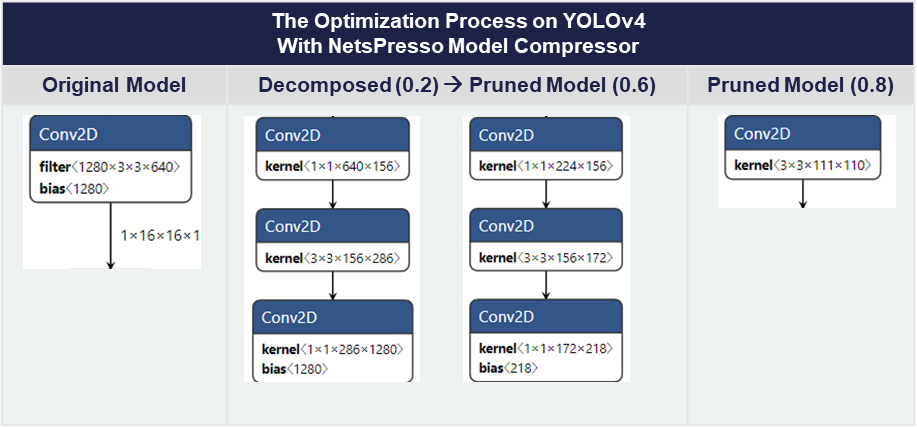
</div>
<div align='center'>Fig. 3 The optimization process for a single convolutional neural network in YOLOv4 with NetsPresso Model Compressor</div>


<a name="acc"></a>
### Accuracy comparision

Evaluation code for the original model

In [ ]:
!python ./keras-YOLOv3-model-set/eval.py --model_path="./yolo4_efficientnet_512_voc.h5" \
--anchors_path="./keras-YOLOv3-model-set/configs/yolo4_anchors.txt" \
--classes_path="./keras-YOLOv3-model-set/configs/voc_classes.txt" \
--model_input_shape=512x512 \
--eval_type=VOC \
--iou_threshold=0.5 \
--conf_threshold=0.001 \
--annotation_file=./keras-YOLOv3-model-set/2007_test.txt \
--save_result

Evaluation code for the compressed model

In [ ]:
# dumping the model
! python ./keras-YOLOv3-model-set/yolo.py \
--model_type=yolo4_efficientnet \
--model_body_path=../yolo4_efficientnet_512_voc_compressed_model.h5 \
--weights_path=../keras-YOLOv3-model-set/logs/000/trained_final.h5 \
--anchors_path=configs/yolo4_anchors.txt \
--classes_path=configs/voc_classes.txt \
--model_input_shape=512x512 \
--dump_model \
--output_model_file=../inf_model.h5

# evaluation the model
! python ./keras-YOLOv3-model-set/eval.py \
--model_path=../inf_model.h5 \
--anchors_path=../keras-YOLOv3-model-set/configs/yolo4_anchors.txt \
--classes_path=../keras-YOLOv3-model-set/configs/voc_classes.txt \
--model_input_shape=512x512 \
--eval_type=VOC \
--iou_threshold=0.5 \
--conf_threshold=0.001 \
--annotation_file=../keras-YOLOv3-model-set/2007_test.txt \
--save_result

<a name="flopsParams"></a>
### FLOPs & Parameters comparision

In [ ]:
import tensorflow as tf
original_model = tf.keras.models.load_model('yolo4_efficientnet_512_voc.h5')
compressed_model = tf.keras.models.load_model('inf_model.h5')

In [ ]:
from keras_flops import get_flops 
import numpy as np
def get_params(model):
    trainable_params = np.sum([np.prod(v.get_shape()) for v in model.trainable_weights])
    non_trainable_params = np.sum([np.prod(v.get_shape()) for v in model.non_trainable_weights])
    return trainable_params + non_trainable_params

original_params = get_params(original_model)/1e6
compressed_params = get_params(compressed_model)/1e6

original_flops = get_flops(original_model,batch_size=1) /1e6
compressed_flops = get_flops(compressed_model,batch_size=1)/1e6

print("\n--- Original model ==> Compressed model ---")
print(f"FLOPs: {round(original_flops,3)}M ==> {round(compressed_flops,3)}M (x{round(original_flops/compressed_flops,3)})")
print(f"Params: {round(original_params,3)}M ==> {round(compressed_params,3)}M (x{round(original_params/compressed_params,3)})")

<a name="latency"></a>
### Latency comparision

In [ ]:
original_tflite_model = tf.lite.TFLiteConverter.from_keras_model(original_model).convert()
compressed_tflite_model = tf.lite.TFLiteConverter.from_keras_model(compressed_model).convert()

with open('original_model.tflite','wb') as f:
    f.write(original_tflite_model)
with open('compressed_model.tflite','wb') as f:
    f.write(compressed_tflite_model)

In [ ]:
import numpy as np
import time
def get_latency(model_path,run_times=100):
  
  interpreter = tf.lite.Interpreter(model_path=model_path)
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()
  output_details = interpreter.get_output_details()

  input_shape = input_details[0]['shape']
  input_data = np.array(np.random.random_sample(input_shape),dtype=np.float32)
  interpreter.set_tensor(input_details[0]['index'],input_data)

  latency = []
  for _ in range(run_times):

    stime=time.perf_counter()
    interpreter.invoke()
    etime=time.perf_counter()

    latency.append(etime-stime)

  # remove warm up time
  latency.pop(0)
  return sum(latency)/len(latency)* 1000 

In [ ]:
original_latency = get_latency('original_model.tflite',run_times=100)
compressed_latency = get_latency('compressed_model.tflite',run_times=100)

print("Original Model ==> Compressed Model")
print(f"Latency: {round(original_latency,3)}ms ==> {round(compressed_latency,3)}ms (x{round(original_latency/compressed_latency,3)})")

<a name="layerShape"></a>

### Architecture of the compressed model

In [ ]:
compressed_model.summary()